In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from matplotlib import pyplot as plt
import xarray as xr
import cmocean.cm as cmo

In [2]:
setup = "ESII_SO"
confi = "RCSI100.L55_ctlv30_030W"

We load the bathymetry and vertical axis created before to know the extent of the configurations domain.

In [3]:
ds_bathy = xr.open_dataset(setup + "-" + confi + "-bathymetry_and_mask.nc", engine='h5netcdf')
xnum = len(ds_bathy.x)
ynum = len(ds_bathy.y)
dx = ds_bathy.x.grid_spacing
dy = ds_bathy.y.grid_spacing

ds_z_axis = xr.open_dataset(setup + "-" + confi + "-vertical_grid.nc", engine='h5netcdf')
z = ds_z_axis["Z"].values

Define latitudinal and longitudinal range to use from ERA5 (the domain of the configuration is then assumed to span approximately this coordinate range for interpolation purposes). Note that these latitudinal and longitudinal bounds should correspond to the ones chosen for the initial conditions (technically, they do not have to, but in most cases it makes not much sense to choose different regions for initial condictions and atmospheric forcing).

In [4]:
lat_min = -75
lat_max = -35
lon_cen = -30

fake_lat = np.linspace(lat_min, lat_max, ynum)

The ERA5 data has been downloaded before with [this notebook](https://github.com/jk-rieck/MITgcm_create_input/blob/main/ERA5_download.ipynb)

In [5]:
# hourly fields
era5 = xr.open_mfdataset("/home/jrieck/ERA5/ERA5_reanalysis_single_levels-1h-1991*.nc", 
                       engine='scipy')

Now we extract the desired (horizontal) domain from the ERA5 dataset and only include values at points where we have `sst` values in order to force our configuration with values that represent conditions over ocean.  
Additionally, we define empty datasets `ds_fit` and `ds_out` to store the calculated quantities for the forcing and save the to disk later on.

In [6]:
ds_ex = era5.sel(latitude=slice(lat_max, lat_min)).where(~np.isnan(era5.sst)).sel(longitude=lon_cen, method='nearest')

/home/jrieck/.venv/py39/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [7]:
ds_ex_3h = ds_ex.resample(time='3H').mean()

Now we define a function that interpolates this to our grid.

In [8]:
def interp(var, ds, lat):
    return ds[var].interp(latitude=lat, method='linear', kwargs={'fill_value': 'extrapolate'})

In [9]:
temperature = np.zeros((len(ds_ex_3h.time), ynum, xnum))
temperature = temperature + interp('t2m', ds_ex_3h, fake_lat).values[:, :, None]

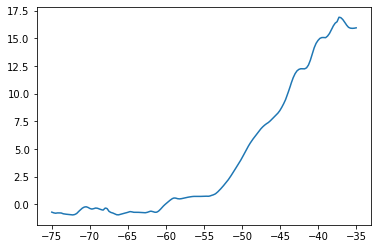

In [10]:
plt.plot(fake_lat, temperature[0, :, 0] - 273.15)

And we repeat the steps above for the remaining variables.

In [12]:
zonal_wind = np.zeros((len(ds_ex_3h.time), ynum, xnum))
zonal_wind = zonal_wind + interp('u10', ds_ex_3h, fake_lat).values[:, :, None]

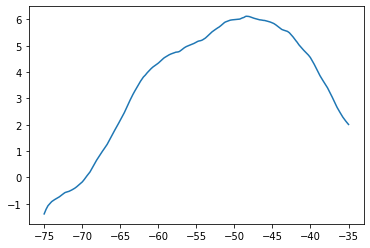

In [13]:
plt.plot(fake_lat, np.mean(zonal_wind[:, :, 0], axis=0))

In [14]:
meridional_wind = np.zeros((len(ds_ex_3h.time), ynum, xnum))
meridional_wind = meridional_wind + interp('v10', ds_ex_3h, fake_lat).values[:, :, None]

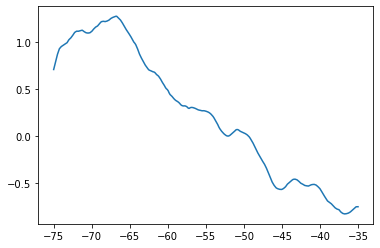

In [15]:
plt.plot(fake_lat, np.mean(meridional_wind[:, :, 0], axis=0))

precipitation is in m per hour. So we need to divide by (60 * 60) seconds to get m/s

In [16]:
precipitation = np.zeros((len(ds_ex_3h.time), ynum, xnum))
precipitation = precipitation + interp('tp', ds_ex_3h, fake_lat).values[:, :, None] / (60 * 60)

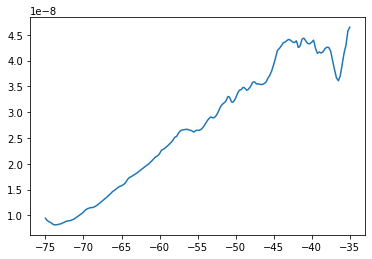

In [17]:
plt.plot(fake_lat, np.mean(precipitation[:, :, 0], axis=0))

Both, shortwave and longwave radiation is in J/m2 per hour. So we need to divide by (60 * 60) seconds to get W/m2

In [18]:
downward_shortwave = np.zeros((len(ds_ex_3h.time), ynum, xnum))
downward_shortwave = downward_shortwave + interp('ssrd', ds_ex_3h, fake_lat).values[:, :, None] / (60 * 60)

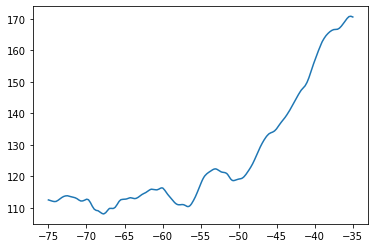

In [20]:
plt.plot(fake_lat, np.mean(downward_shortwave[:, :, 0], axis=0))

In [21]:
downward_longwave = np.zeros((len(ds_ex_3h.time), ynum, xnum))
downward_longwave = downward_longwave + interp('strd', ds_ex_3h, fake_lat).values[:, :, None] / (60 * 60)

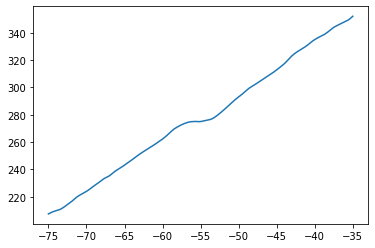

In [22]:
plt.plot(fake_lat, np.mean(downward_longwave[:, :, 0], axis=0))

Here we calculate specific humidity in the same manner that the MITgcm [`EXF`](https://mitgcm.readthedocs.io/en/latest/phys_pkgs/exf.html#run-time-parameters) package would calculate it. We assume a constant relative humidity of 70%.

In [23]:
cvapor_fac = 640380.0
cvapor_exp = 5107.4
atmrho = 1.2
rh=70
tmpbulk = cvapor_fac * np.exp(-cvapor_exp / temperature)
specific_humidity = (rh/100.) * tmpbulk / atmrho

__Runoff__ is estimated based on calving fluxes and basal melt rates reported by [Depoorter et al. (2013)](https://www.nature.com/articles/nature12567). They estimate a total runoff of 2775 Gt/year for Antarctica. Taking into account the total length of the 75$^{\circ}$S parallel is approximately 10405 km, the runoff per km of "coastline" is 0.267 Gt/year. We take the 75$^{\circ}$S parallel as an approximation to the Antarctic coastline as it is exactly that in our simulation. The length of the coastline in this configuration is 2400 km, so that we estimate a runoff of ~641 Gt/year for our configuration (equivalent to ~22173 m$^{3}$/s, assuming an ice density of 916.7 kg/m$^{3}$):  
$ro = 641 \frac{Gt}{year} = 641 \times 10^{12}\frac{kg}{year}$  
$ro = \frac{641 \times 10^{12} \frac{kg}{year}}{(60 * 60 * 24 * 365) \frac{s}{year}} \sim  20.3 \times 10^{6} \frac{kg}{s}$  
$ro \sim  \frac{20.3 \times 10^{6} \frac{kg}{s}}{916.7 \frac{kg}{m^{3}}} \sim 22173 \frac{m^{3}}{s}$   
This runoff is distributed among the surface near-shore grid cells of the domain as illustrated below. Liquid runoff from Antarctica is neglected. Note that the runoff does not have a seasonal cycle, i.e. the runoff of Antarctica is assumed to be constant throughout the year. 

First, we define how big the cells are (area) depending on the horizontal grid.

In [24]:
area = (dx * 1e3) * (dy * 1e3)

In [25]:
runoff = np.zeros(np.shape(downward_longwave[0:1,...]))

We distribute the runoff within the first 10 grid cells away from the coast, to account for ice that is moved northward before melting. The cells closest to the coast get more runoff (this could be interpreted as the ice shelf basal melt contributing more to the runoff directly at the coast).

In [26]:
runoff[:, 1:5, :] = 1
runoff[:, 5:8, :] = 0.5
runoff[:, 8:10, :] = 0.25

In [27]:
number_runoff = np.sum(runoff) # calculate the weighted number of cells that should receive runoff
area_runoff = number_runoff * area # calculate the total area of all the cells that receive runoff
runoff *= 22173 / area_runoff # divide the total runoff by the total area and distribute this same fraction to every grid cell defined above

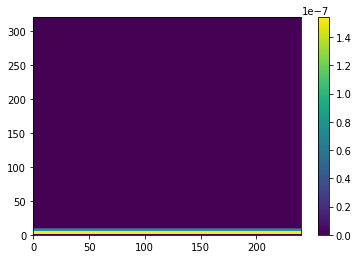

In [28]:
plt.pcolormesh(runoff.squeeze())
plt.colorbar()

We create a field containing only zeros in case we want to switch off one forcing field for tests later on. (E.g. no runoff, no precipitation etc.)

In [29]:
only_zeros = zonal_wind * 0.

We save the variables as big endian single precision floats to binary files for the MITgcm to read them.

In [30]:
zonal_wind.astype(">f4").tofile(setup + "-" + confi + "-era5_zonal_wind.bin")
meridional_wind.astype(">f4").tofile(setup + "-" + confi + "-era5_meridional_wind.bin")
temperature.astype(">f4").tofile(setup + "-" + confi + "-era5_temperature.bin")
runoff.astype(">f4").tofile(setup + "-" + confi + "-era5_runoff.bin")
precipitation.astype(">f4").tofile(setup + "-" + confi + "-era5_precipitation.bin")
downward_longwave.astype(">f4").tofile(setup + "-" + confi + "-era5_downward_longwave.bin")
downward_shortwave.astype(">f4").tofile(setup + "-" + confi + "-era5_downward_shortwave.bin")
specific_humidity.astype(">f4").tofile(setup + "-" + confi + "-era5_specific_humidity.bin")
only_zeros.astype(">f4").tofile(setup + "-" + confi + "-input_only_zeros.bin")

In [31]:
ds_out = xr.Dataset(coords={'time': ds_ex_3h['time'], 'x': ds_bathy.x, 'y': ds_bathy.y})
ds_out = ds_out.assign(variables={"temperature": (('time', 'y', 'x'), temperature)})
ds_out["temperature"].attrs = {"units": "deg K"}
ds_out = ds_out.assign(variables={"zonal_wind": (('time', 'y', 'x'), zonal_wind)})
ds_out["zonal_wind"].attrs = {"units": "m/s"}
ds_out = ds_out.assign(variables={"meridional_wind": (('time', 'y', 'x'), meridional_wind)})
ds_out["meridional_wind"].attrs = {"units": "m/s"}
ds_out = ds_out.assign(variables={"precipitation": (('time', 'y', 'x'), precipitation)})
ds_out["precipitation"].attrs = {"units": "m/s"}
ds_out = ds_out.assign(variables={"downward_shortwave": (('time', 'y', 'x'), downward_shortwave)})
ds_out["downward_shortwave"].attrs = {"units": "W/m^2"}
ds_out = ds_out.assign(variables={"downward_longwave": (('time', 'y', 'x'), downward_longwave)})
ds_out["downward_longwave"].attrs = {"units": "W/m^2"}
ds_out = ds_out.assign(variables={"specific_humidity": (('time', 'y', 'x'), specific_humidity)})
ds_out["specific_humidity"].attrs = {"units": "kg/kg"}
ds_out = ds_out.assign(variables={"runoff": (('y', 'x'), runoff.squeeze())})
ds_out["runoff"].attrs = {"units": "m/s"}
ds_out.to_netcdf(setup + "-" + confi + "-era5-atmospheric_forcing.nc", engine='h5netcdf')

/home/jrieck/.venv/py39/lib/python3.9/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)
